In [44]:
from google.colab import drive

drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive"
FOLDERNAME = "Datathon2026/data"
DATA_DIR = f"{BASE_DIR}/{FOLDERNAME}"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")


In [46]:
df = pd.read_csv(f"{DATA_DIR}/cleaned_data.csv")


In [47]:
df.columns

Index(['State', 'County', 'Year', 'Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10', 'log_max_aqi', 'pct_good_days',
       'pct_moderate_days', 'pct_unhealthy_for_sensitive_groups_days',
       'pct_unhealthy_days', 'pct_very_unhealthy_days', 'pct_hazardous_days',
       'pct_unhealthy_plus', 'max_to_median', 'p90_to_median', 'pct_days_co',
       'pct_days_no2', 'pct_days_ozone', 'pct_days_pm2.5', 'pct_days_pm10'],
      dtype='object')

# Data preparation

## Add unique county x year label

In [48]:
df["county_id"] = df["State"].astype(str) + " | " + df["County"].astype(str)


## Sort data for rolling 

In [49]:
df = df.sort_values(["county_id", "Year"]).reset_index(drop=True)


## Find top 10% threashhold for each year

As top 10% may vary between years, we need to indicate which county in that specific year have top 10% `MAX AQI`

`is_extreme_this_year`: 
- 1 = `MAX AQI` greater or equal to 90% threshold of that specific year
- 0 = `MAX AQI` smaller 90% threshold of that specific year


In [50]:
q = 0.90

year_thr = df.groupby("Year")["Max AQI"].quantile(q).rename("thr_max_aqi").reset_index()

df = df.merge(year_thr, on="Year", how="left")

df["is_extreme_this_year"] = (df["Max AQI"] >= df["thr_max_aqi"]).astype(int)


## Add Prediction target

To predict next year’s extreme AQI, we shift `is_extreme_this_year` by one year within each county so that future outcomes are aligned with the current year.

In [51]:
H = 1 

g = df.groupby("county_id", group_keys=False)

future_flags = []
for k in range(1, H + 1):
    future_flags.append(g["is_extreme_this_year"].shift(-k))

df["label_extreme_next_1y"] = (
    pd.concat(future_flags, axis=1).max(axis=1).fillna(0).astype(int)
)

# Feature Engineer

## Rolling Feature Definitions

All rolling features and trend are computed **by county (`county_id`)** using **only past data**:
- Series is shifted by 1 year to avoid leakage  
- Rolling windows use `min_periods = 3`

The trend is computed as the **slope of a linear fit** (OLS) of the variable against time.

---

### Baseline air quality (slow-changing)

- **`roll5_mean_median_aqi`**  
  Past 5-year average Median AQI → recent baseline level

- **`roll10_mean_median_aqi`**  
  Past 10-year average Median AQI → long-term baseline

- **`roll10_std_median_aqi`**  
  10-year std of Median AQI → baseline instability

---

### Exposure severity

- **`roll5_mean_pct_unhealthy_plus`**  
  Past 5-year average unhealthy+ day share → recent exposure

- **`roll10_mean_pct_unhealthy_plus`**  
  Past 10-year average unhealthy+ day share → chronic exposure

- **`roll10_std_pct_unhealthy_plus`**  
  10-year std of unhealthy+ day share → exposure variability

---

### Extreme risk / spikes

- **`roll5_max_log_max_aqi`**  
  Max log(Max AQI) in past 5 years → recent extreme intensity

- **`roll10_max_log_max_aqi`**  
  Max log(Max AQI) in past 10 years → historical extreme risk

- **`roll5_mean_p90_to_median`**  
  Past 5-year mean of p90 / median AQI → spike tendency

---

### Temporal memory

- **`year_since_extreme`**  
  Years since last extreme AQI event → persistence of risk

---
### Long-term trend

- **`trend10_median_aqi`**  
  Linear slope of Median AQI in past 10 years → baseline air quality trend 

- **`trend10_pct_unhealthy_plus`**  
  Linear slope of unhealthy+ day in past 10 years →  exposure is trend
---


### Summary Table

| Feature | Window | Statistic | Signal Type |
|------|------|-----------|------------|
| roll5_mean_median_aqi | 5 | Mean | Recent baseline |
| roll10_mean_median_aqi | 10 | Mean | Long-term baseline |
| roll10_std_median_aqi | 10 | Std | Baseline instability |
| roll5_mean_pct_unhealthy_plus | 5 | Mean | Recent exposure |
| roll10_mean_pct_unhealthy_plus | 10 | Mean | Long-term exposure |
| roll10_std_pct_unhealthy_plus | 10 | Std | Exposure variability |
| roll5_max_log_max_aqi | 5 | Max | Recent extremes |
| roll10_max_log_max_aqi | 10 | Max | Historical extremes |
| roll5_mean_p90_to_median | 5 | Mean | Spike variability |
| trend10_median_aqi | 10 | Slope | Baseline trend |
| trend10_pct_unhealthy_plus | 10 | Slope | Exposure trend |
| year_since_extreme | - | Count | Temporal risk memory |


These rolling features together separate **background level**, **chronic exposure**, and **extreme-event risk**, which is useful for both prediction and interpretation.


In [52]:
def add_rolling_mean(df, col, win, new_name):
    g = df.groupby("county_id")[col]
    df[new_name] = g.transform(lambda s: s.shift(1).rolling(win, min_periods=3).mean())
    return df


def add_rolling_max(df, col, win, new_name):
    g = df.groupby("county_id")[col]
    df[new_name] = g.transform(lambda s: s.shift(1).rolling(win, min_periods=3).max())
    return df

def add_rolling_std(df, col, win, new_name):
    g = df.groupby("county_id")[col]
    df[new_name] = g.transform(lambda s: s.shift(1).rolling(win, min_periods=3).std())
    return df

df = add_rolling_mean(df, "Median AQI", 5, "roll5_mean_median_aqi")
df = add_rolling_mean(df, "Median AQI", 10, "roll10_mean_median_aqi")

df = add_rolling_mean(df, "pct_unhealthy_plus", 5, "roll5_mean_pct_unhealthy_plus")
df = add_rolling_mean(df, "pct_unhealthy_plus", 10, "roll10_mean_pct_unhealthy_plus")

df = add_rolling_max(df, "log_max_aqi", 5, "roll5_max_log_max_aqi")
df = add_rolling_max(df, "log_max_aqi", 10, "roll10_max_log_max_aqi")

df = add_rolling_mean(df, "p90_to_median", 5, "roll5_mean_p90_to_median")

df = add_rolling_std(df, "Median AQI", 10, "roll10_std_median_aqi")
df = add_rolling_std(df, "pct_unhealthy_plus", 10, "roll10_std_pct_unhealthy_plus")

df["year_since_extreme"] = np.nan
for cid, sub in df.groupby("county_id"):
    last = None
    out = []
    for yr, flag in zip(sub["Year"], sub["is_extreme_this_year"]):
        if last is None:
            out.append(np.nan)
        else:
            out.append(yr - last)
        if flag == 1:
            last = yr
    df.loc[sub.index, "year_since_extreme"] = out


## Simple linear regression slope for past window

`trend10_median_aqi`: For each county-year, the slope of a linear fit of Median AQI over the previous up to 10 years, capturing long-term improvement or deterioration.

`trend10_pct_unhealthy_plus`: Same slope-based trend computed on pct_unhealthy_plus, capturing whether unhealthy exposure is increasing or decreasing over the past decade.

In [53]:
def rolling_slope(y):
    x = np.arange(len(y))
    mask = ~np.isnan(y)
    if mask.sum() < 3:
        return np.nan
    x = x[mask]
    y = y[mask]
    x_mean = x.mean()
    y_mean = y.mean()
    denom = ((x - x_mean) ** 2).sum()
    if denom == 0:
        return np.nan
    return ((x - x_mean) * (y - y_mean)).sum() / denom


def add_trend(df, col, win, new_name):
    def f(s):
        s2 = s.shift(1)
        return s2.rolling(win, min_periods=5).apply(
            lambda arr: rolling_slope(arr.values), raw=False
        )

    df[new_name] = df.groupby("county_id")[col].transform(f)
    return df


df = add_trend(df, "Median AQI", 10, "trend10_median_aqi")
df = add_trend(df, "pct_unhealthy_plus", 10, "trend10_pct_unhealthy_plus")


In [54]:
meta_cols = ["State", "County", "county_id", "Year"]
label_col = "label_extreme_next_1y"
base_features = [
    "pct_unhealthy_plus",
    "Median AQI",
    "max_to_median",
    "p90_to_median",

    "pct_days_co",
    "pct_days_no2",
    "pct_days_ozone",
    "pct_days_pm2.5",
    "pct_days_pm10",
]
engineered_features = [
    "roll5_mean_median_aqi",
    "roll10_mean_median_aqi",
    "roll5_mean_pct_unhealthy_plus",
    "roll10_mean_pct_unhealthy_plus",
    "roll5_max_log_max_aqi",
    "roll10_max_log_max_aqi",
    "roll5_mean_p90_to_median",
    "trend10_median_aqi",
    "trend10_pct_unhealthy_plus",
    "year_since_extreme",
    "roll10_std_median_aqi",
    "roll10_std_pct_unhealthy_plus",
]


In [55]:
feature_cols = base_features + engineered_features

model_df = df[meta_cols + feature_cols + [label_col]].copy()

model_df = model_df.dropna(subset=[label_col])

must_have = [
    "roll5_mean_median_aqi",
    "roll5_mean_pct_unhealthy_plus",
    "roll5_max_log_max_aqi",
]
model_df = model_df.dropna(subset=must_have)

model_df.head()


,State,County,county_id,Year,pct_unhealthy_plus,Median AQI,max_to_median,p90_to_median,pct_days_co,pct_days_no2,...,roll10_mean_pct_unhealthy_plus,roll5_max_log_max_aqi,roll10_max_log_max_aqi,roll5_mean_p90_to_median,trend10_median_aqi,trend10_pct_unhealthy_plus,year_since_extreme,roll10_std_median_aqi,roll10_std_pct_unhealthy_plus,label_extreme_next_1y
3,Alabama,Baldwin,Alabama | Baldwin,2003,0.003597,45,3.866667,1.711111,0.0,0.0,...,0.016623,5.327876,5.327876,1.940901,NaN,NaN,NaN,6.244998,0.022945,0
4,Alabama,Baldwin,Alabama | Baldwin,2004,0.000000,46,3.108696,1.847826,0.0,0.0,...,0.013366,5.327876,5.327876,1.883454,NaN,NaN,NaN,5.315073,0.019834,0
5,Alabama,Baldwin,Alabama | Baldwin,2005,0.000000,49,3.000000,1.632653,0.0,0.0,...,0.010693,5.327876,5.327876,1.876328,-1.900000,-0.008907,NaN,4.636809,0.018187,0
6,Alabama,Baldwin,Alabama | Baldwin,2006,0.003571,50,3.120000,1.940000,0.0,0.0,...,0.008911,5.164786,5.327876,1.733768,-0.800000,-0.006617,NaN,4.226898,0.016843,0
7,Alabama,Baldwin,Alabama | Baldwin,2007,0.003717,46,3.347826,1.891304,0.0,0.0,...,0.008148,5.164786,5.327876,1.756551,-0.214286,-0.004708,NaN,3.988077,0.015507,0


In [56]:
print("rows:", len(model_df))
print("counties:", model_df["county_id"].nunique())
print("years range:", model_df["Year"].min(), "-", model_df["Year"].max())
print("positive rate:", model_df[label_col].mean())


rows: 27551
counties: 1106
years range: 1983 - 2025
positive rate: 0.10580378207687562


# Modeling

## Model Components Overview

### Recall@Top10%
A ranking-based evaluation metric that measures how many true extreme AQI events are captured within the top 10% of highest-risk predictions.

**Why we use it:**  
Extreme AQI events are rare, and in practice only a limited number of high-risk county-years can be prioritized. Recall@Top10% evaluates the model’s ability to correctly identify extreme events among the most critical cases, which is more relevant than accuracy in imbalanced risk prediction settings.

---

### GroupKFold
A cross-validation strategy that splits data based on predefined groups, here using `county_id`.

**Why we use it:**  
All observations from the same county are kept in either the training set or the test set, but never both. This prevents information leakage across years within the same county.

---

### Logistic Regression
A linear probabilistic classification model that estimates the likelihood of an extreme AQI event.

**Why we use it:**  
Logistic regression provides a strong, interpretable baseline for binary risk prediction. With class weighting, it handles class imbalance and produces calibrated risk scores well.


In [57]:
X = model_df[feature_cols]
y = model_df[label_col].astype(int)
groups = model_df["county_id"]

gkf = GroupKFold(n_splits=5)

pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, n_jobs=-1)),
    ]
)


In [58]:
def recall_at_k(y_true: pd.Series, y_score: np.ndarray, k: float = 0.10) -> float:
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score)

    n = len(y_true)
    cutoff = max(1, int(n * k))
    idx = np.argsort(y_score)[::-1][:cutoff]

    total_pos = y_true.sum()
    if total_pos == 0:
        return np.nan

    tp = y_true[idx].sum()
    return float(tp / total_pos)


def cumulative_recall_curve(y_true: np.ndarray, y_score: np.ndarray, ks=None):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score)

    if ks is None:
        ks = np.linspace(0.01, 0.30, 30) 

    order = np.argsort(y_score)[::-1]
    y_sorted = y_true[order]

    total_pos = y_sorted.sum()
    if total_pos == 0:
        return ks, np.full_like(ks, np.nan, dtype=float)

    cumsum_pos = np.cumsum(y_sorted)

    recalls = []
    n = len(y_sorted)
    for k in ks:
        cutoff = max(1, int(n * k))
        tp = cumsum_pos[cutoff - 1]
        recalls.append(tp / total_pos)

    return np.array(ks), np.array(recalls)


## K-fold validation model

In [59]:
fold_rows = []
fold_rocs = []  
fold_prs = []  

oof_y = np.zeros(len(y), dtype=int)
oof_p = np.zeros(len(y), dtype=float)

for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]

    pipe.fit(X_tr, y_tr)
    p = pipe.predict_proba(X_te)[:, 1]

    oof_y[te] = y_te.values
    oof_p[te] = p

    auc = roc_auc_score(y_te, p)
    r10 = recall_at_k(y_te, p, k=0.10)
    fold_rows.append({"fold": fold, "AUC": auc, "Recall@Top10%": r10})

    fpr, tpr, _ = roc_curve(y_te, p)
    fold_rocs.append({"fold": fold, "fpr": fpr, "tpr": tpr, "auc": auc})

    precision, recall, _ = precision_recall_curve(y_te, p)
    ap = average_precision_score(y_te, p)
    fold_prs.append({"fold": fold, "precision": precision, "recall": recall, "ap": ap})

    print(f"Fold {fold}: AUC = {auc:.3f}, Recall@Top10% = {r10:.3f}, AP = {ap:.3f}")

fold_df = pd.DataFrame(fold_rows)
print("\n====================")
print(f"Mean AUC: {fold_df['AUC'].mean():.4f} ± {fold_df['AUC'].std():.4f}")
print(
    f"Mean Recall@Top10%: {fold_df['Recall@Top10%'].mean():.4f} ± {fold_df['Recall@Top10%'].std():.4f}"
)
print("====================\n")


Fold 0: AUC = 0.810, Recall@Top10% = 0.416, AP = 0.423
Fold 1: AUC = 0.829, Recall@Top10% = 0.433, AP = 0.477
Fold 2: AUC = 0.812, Recall@Top10% = 0.434, AP = 0.445
Fold 3: AUC = 0.850, Recall@Top10% = 0.472, AP = 0.536
Fold 4: AUC = 0.825, Recall@Top10% = 0.440, AP = 0.460

Mean AUC: 0.8252 ± 0.0159
Mean Recall@Top10%: 0.4390 ± 0.0203



### ROC Curve

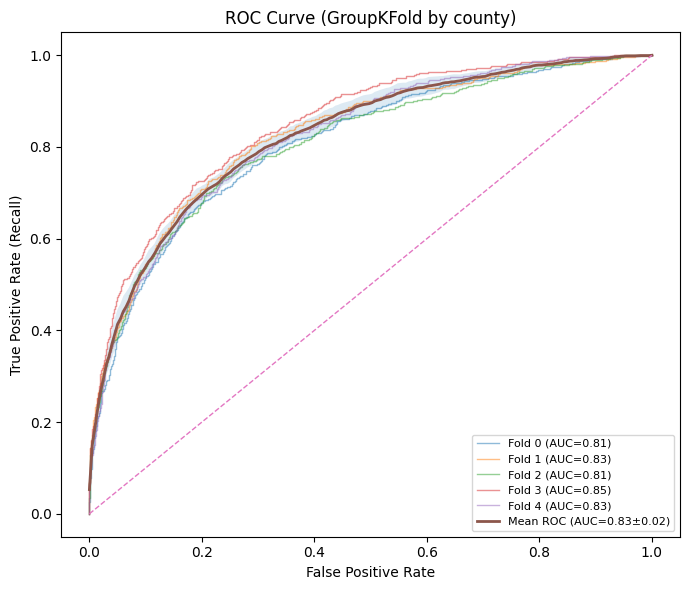

In [60]:
plt.figure(figsize=(7, 6))

for d in fold_rocs:
    plt.plot(
        d["fpr"],
        d["tpr"],
        linewidth=1,
        alpha=0.5,
        label=f"Fold {d['fold']} (AUC={d['auc']:.2f})",
    )

mean_fpr = np.linspace(0, 1, 200)
tprs_interp = []
for d in fold_rocs:
    tprs_interp.append(np.interp(mean_fpr, d["fpr"], d["tpr"]))
mean_tpr = np.mean(tprs_interp, axis=0)
std_tpr = np.std(tprs_interp, axis=0)

plt.plot(
    mean_fpr,
    mean_tpr,
    linewidth=2,
    label=f"Mean ROC (AUC={fold_df['AUC'].mean():.2f}±{fold_df['AUC'].std():.2f})",
)
plt.fill_between(
    mean_fpr,
    np.clip(mean_tpr - std_tpr, 0, 1),
    np.clip(mean_tpr + std_tpr, 0, 1),
    alpha=0.15,
)

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (GroupKFold by county)")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()


The ROC curves show strong and stable ranking performance across counties, with a mean AUC of 0.83, indicating reliable discrimination between extreme and non-extreme years.

### Precision Recall Curve

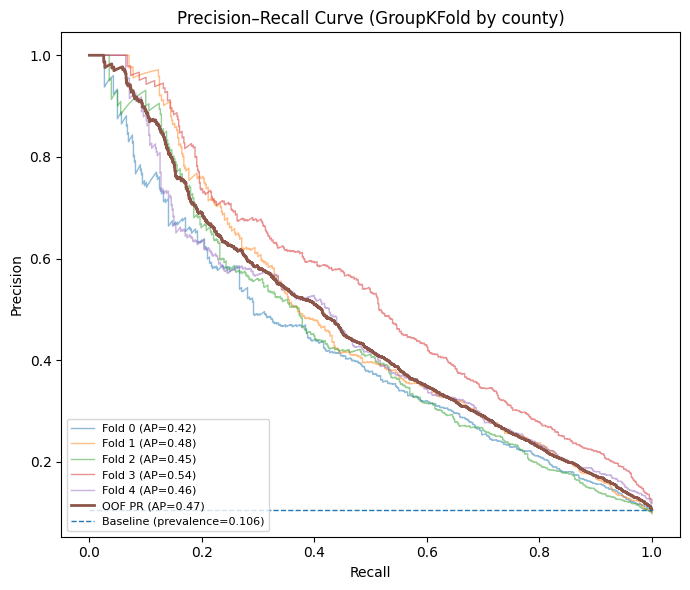

In [61]:
plt.figure(figsize=(7, 6))

for d in fold_prs:
    plt.plot(
        d["recall"],
        d["precision"],
        linewidth=1,
        alpha=0.5,
        label=f"Fold {d['fold']} (AP={d['ap']:.2f})",
    )

oof_precision, oof_recall, _ = precision_recall_curve(oof_y, oof_p)
oof_ap = average_precision_score(oof_y, oof_p)
plt.plot(oof_recall, oof_precision, linewidth=2, label=f"OOF PR (AP={oof_ap:.2f})")

prevalence = oof_y.mean()
plt.hlines(
    prevalence,
    0,
    1,
    linestyles="--",
    linewidth=1,
    label=f"Baseline (prevalence={prevalence:.3f})",
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (GroupKFold by county)")
plt.legend(loc="lower left", fontsize=8)
plt.tight_layout()
plt.show()


Compared to the baseline prevalence of extreme events, the model substantially improves precision across recall levels, confirming its usefulness in a highly imbalanced setting.

### Cumulative Recall Curve

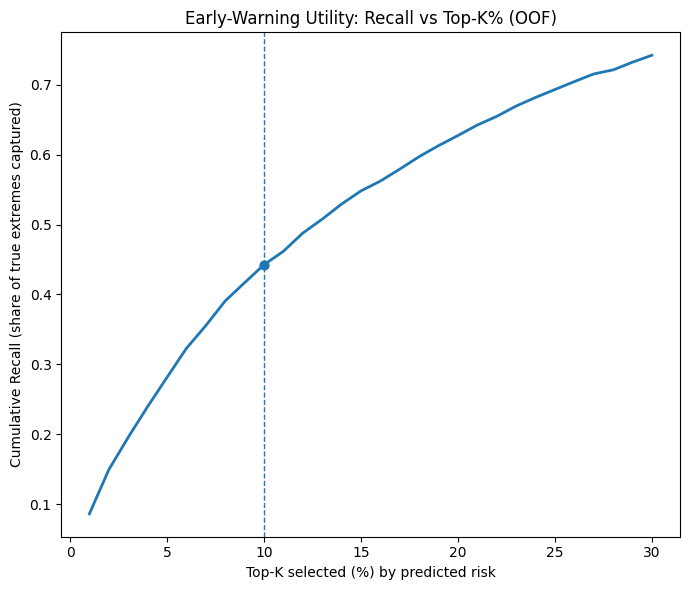

In [62]:
ks, recs = cumulative_recall_curve(oof_y, oof_p, ks=np.linspace(0.01, 0.30, 30))

plt.figure(figsize=(7, 6))
plt.plot(ks * 100, recs, linewidth=2)

k0 = 0.10
k_idx = np.argmin(np.abs(ks - k0))
plt.scatter([ks[k_idx] * 100], [recs[k_idx]], s=40)
plt.axvline(k0 * 100, linestyle="--", linewidth=1)

plt.xlabel("Top-K selected (%) by predicted risk")
plt.ylabel("Cumulative Recall (share of true extremes captured)")
plt.title("Early-Warning Utility: Recall vs Top-K% (OOF)")
plt.tight_layout()
plt.show()


The model concentrates risk effectively: by monitoring only the top 10% highest-risk county-years, we can capture nearly half of all extreme AQI events.

In [63]:
import numpy as np
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

X_sm = model_df[feature_cols].copy()
y_sm = model_df[label_col].copy()

imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_sm)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)
X_scaled = sm.add_constant(X_scaled)

logit = sm.Logit(y_sm, X_scaled)
result = logit.fit()

summary_table = result.summary2().tables[1]
summary_table.index = ["Intercept"] + feature_cols
summary_table["Odds_Ratio"] = np.exp(summary_table["Coef."])


def sig_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


summary_table["sig"] = summary_table["P>|z|"].apply(sig_stars)

pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)
print(summary_table[["Coef.", "Std.Err.", "z", "P>|z|", "Odds_Ratio", "sig"]])


Optimization terminated successfully.
         Current function value: 0.258912
         Iterations 15
                                   Coef.      Std.Err.             z         P>|z|  Odds_Ratio  sig
Intercept                      -2.610586  2.877267e-02 -9.073146e+01  0.000000e+00    0.073491  ***
pct_unhealthy_plus              0.247684  4.364177e-02  5.675395e+00  1.383690e-08    1.281055  ***
Median AQI                      0.093556  5.174004e-02  1.808201e+00  7.057524e-02    1.098073     
max_to_median                   0.758582  9.980507e-02  7.600633e+00  2.946861e-14    2.135246  ***
p90_to_median                   0.023803  3.281184e-02  7.254346e-01  4.681855e-01    1.024088     
pct_days_co                    -0.138290  1.132419e+06 -1.221193e-07  9.999999e-01    0.870846     
pct_days_no2                   -0.054654  1.252384e+06 -4.363987e-08  1.000000e+00    0.946813     
pct_days_ozone                 -0.238231  2.788924e+06 -8.542025e-08  9.999999e-01    0.788021   

### Statitical Summary
- Recent and persistent unhealthy exposure is the strongest predictor of future extreme AQI events. A one–standard deviation increase in the 10-year average of unhealthy days increases the odds of an extreme event by nearly 4×
- Extreme intensity history matters more than central tendency. Long-term extreme spikes (`roll10_max_log_max_aqi`) and tail severity (`max_to_median`, `p90_to_median`) are highly significant, while median AQI alone is weakly predictive.
- Temporal memory is important. Each additional year since the last extreme event reduces the odds of a new extreme by about 30%, indicating strong temporal clustering of extremes.
- The negative relationship between short-term and long-term unhealthy exposure suggests heterogeneous trends across counties, with some showing recent improvement and others facing increasing air quality stress.
- Pollutant mix shares are not independently significant once severity and history are controlled for, suggesting their effects are largely mediated through overall exposure and extremes.

## Feature Engineering based on Statisticial Evidence

### Long Term & Current Exposure
- `roll10_mean_pct_unhealthy_plus`: Chronic Exposure

Long-run average frequency of unhealthy or worse AQI days, capturing persistent public health burden.

- `pct_unhealthy_plus`: Current Stress

Share of unhealthy AQI days in the current year, reflecting immediate environmental stress.

### Strength of Extreme Case
- `max_to_median`: Single year spike vs Baseline

Ratio between the worst AQI day and typical conditions in the same year, measuring extreme intensity.

- `roll10_max_log_max_aqi`: Historical worst cases

Maximum logged AQI observed over the past decade, representing the upper tail risk.

- `roll5_mean_p90_to_median`: Recent year spike frequency

Typical gap between high-pollution days and normal conditions in recent years, capturing repeated spikes.

### Memory & Trends
- `delta_5y_vs_10y_unhealthy`: Acceleration / Direction of change

Typical gap between high-pollution days and normal conditions in recent years, capturing repeated spikes.

- `year_since_extreme`: Chronic Memoey of events

Number of years since the last extreme AQI event, capturing temporal clustering of extremes.

### Stability & Uncertainty
- `roll10_std_median_aqi`: Chance of uncertainty
 
Long-term variability in typical air quality, indicating instability and uncertainty around the baseline.


| Feature Name | Category | Short Description | Real-world implication |
|---|---|---|---|
| roll10_mean_pct_unhealthy_plus | Long-term exposure | 10-year average share of unhealthy or worse AQI days | Long-term health burden |
| pct_unhealthy_plus | Current exposure | Share of unhealthy AQI days in the current year | Immediate health risk |
| max_to_median | Extreme intensity | Ratio of worst AQI day to typical conditions in the same year | Single extreme event |
| roll10_max_log_max_aqi | Extreme history | Highest logged AQI seen in the past 10 years | Past severe disaster |
| roll5_mean_p90_to_median | Recent extremes | Recent gap between high-pollution days and normal conditions | Repeated spikes |
| delta_5y_vs_10y_unhealthy | Trend | Difference between 5-year and 10-year unhealthy-day rates | Worsening or improving |
| year_since_extreme | Event memory | Years since the last extreme AQI event | Years without wildfire |
| roll10_std_median_aqi | Stability | 10-year variability of median AQI | Unstable air quality |



In [64]:
model_df["delta_5y_vs_10y_unhealthy"] = (
    model_df["roll5_mean_pct_unhealthy_plus"]
    - model_df["roll10_mean_pct_unhealthy_plus"]
)

core_features = [
    "roll10_mean_pct_unhealthy_plus",
    "max_to_median",
    "pct_unhealthy_plus",
    "roll10_max_log_max_aqi",
    "roll5_mean_p90_to_median",
    "year_since_extreme",
    "roll10_std_median_aqi",
    "delta_5y_vs_10y_unhealthy",
]


## Model Comparison

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


X = model_df[core_features].copy()
y = model_df[label_col].astype(int).copy()
groups = model_df["county_id"].copy()

gkf = GroupKFold(n_splits=5)


def recall_at_k(y_true, y_score, k=0.10):
    n = len(y_true)
    cutoff = max(1, int(n * k))
    idx = np.argsort(y_score)[::-1][:cutoff]
    tp = y_true.iloc[idx].sum()
    total_pos = y_true.sum()
    return float(tp / max(1, total_pos))

models = {
    "LogReg": Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            (
                "clf",
                LogisticRegression(class_weight="balanced", max_iter=3000, n_jobs=-1),
            ),
        ]
    ),
    "LightGBM": Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            (
                "clf",
                LGBMClassifier(
                    n_estimators=800,
                    learning_rate=0.03,
                    num_leaves=31,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ]
    ),
    "XGBoost": Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            (
                "clf",
                XGBClassifier(
                    n_estimators=900,
                    learning_rate=0.03,
                    max_depth=4,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_lambda=1.0,
                    min_child_weight=1.0,
                    random_state=42,
                    n_jobs=-1,
                    eval_metric="logloss",
                    tree_method="hist",
                    scale_pos_weight=1.0, 
                ),
            ),
        ]
    ),
}

rows = []
for name, model in models.items():
    aucs, r10s = [], []

    for fold, (tr, te) in enumerate(gkf.split(X, y, groups)):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        pos_tr = int(y_tr.sum())
        neg_tr = int(len(y_tr) - pos_tr)
        spw = float(neg_tr / max(1, pos_tr))

        if name in ["XGBoost", "LightGBM"]:
            model.set_params(clf__scale_pos_weight=spw)

        model.fit(X_tr, y_tr)
        p = model.predict_proba(X_te)[:, 1]

        aucs.append(roc_auc_score(y_te, p))
        r10s.append(recall_at_k(y_te, p, k=0.10))

    rows.append(
        {
            "model": name,
            "AUC_mean": float(np.mean(aucs)),
            "AUC_std": float(np.std(aucs)),
            "Recall10_mean": float(np.mean(r10s)),
            "Recall10_std": float(np.std(r10s)),
        }
    )

res = pd.DataFrame(rows).sort_values("AUC_mean", ascending=False)
display(res)


[LightGBM] [Info] Number of positive: 2353, number of negative: 19687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 22040, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.106760 -> initscore=-2.124267
[LightGBM] [Info] Start training from score -2.124267
[LightGBM] [Info] Number of positive: 2361, number of negative: 19680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 22041, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.107119 -> initscore=-2.120518
[LightGBM] [Info] Start training from score -2.120518
[LightGBM] [Info

,model,AUC_mean,AUC_std,Recall10_mean,Recall10_std
2,XGBoost,0.826007,0.011911,0.457750,0.010038
1,LightGBM,0.816941,0.009949,0.447450,0.018323
0,LogReg,0.800233,0.017866,0.426003,0.012811


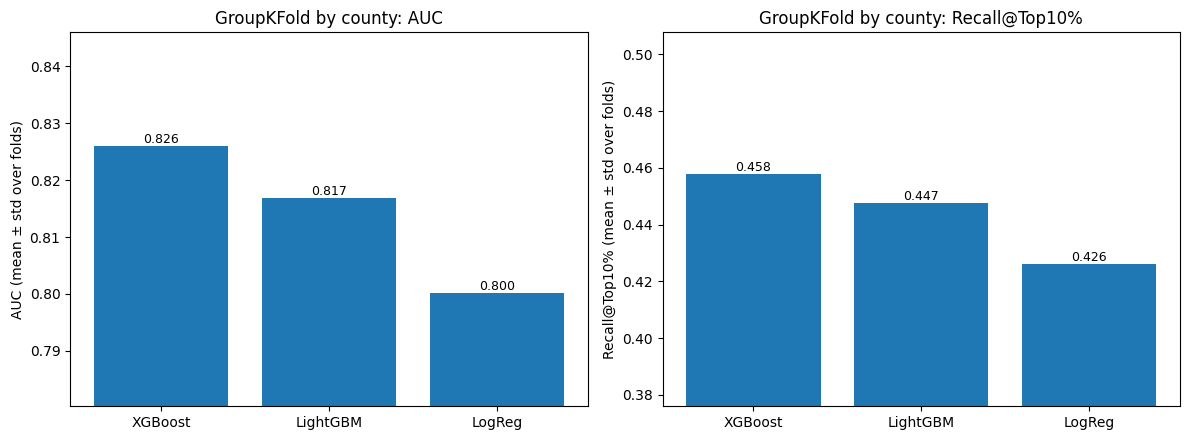

In [66]:
labels = res["model"].tolist()
x = np.arange(len(labels))

auc_mean = res["AUC_mean"].to_numpy()

r10_mean = res["Recall10_mean"].to_numpy()
r10_std = res["Recall10_std"].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

axes[0].bar(x, auc_mean, capsize=4)
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels, rotation=0)
axes[0].set_ylabel("AUC (mean ± std over folds)")
axes[0].set_title("GroupKFold by county: AUC")

auc_lo = float(np.min(auc_mean))
auc_hi = float(np.max(auc_mean))
pad = 0.02
axes[0].set_ylim(max(0.0, auc_lo - pad), min(1.0, auc_hi + pad))

for i, v in enumerate(auc_mean):
    axes[0].text(i, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

axes[1].bar(x, r10_mean, capsize=4)
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels, rotation=0)
axes[1].set_ylabel("Recall@Top10% (mean ± std over folds)")
axes[1].set_title("GroupKFold by county: Recall@Top10%")

r_lo = float(np.min(r10_mean))
r_hi = float(np.max(r10_mean))
pad = 0.05
axes[1].set_ylim(max(0.0, r_lo - pad), min(1.0, r_hi + pad))

for i, v in enumerate(r10_mean):
    axes[1].text(i, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)


plt.tight_layout()
plt.show()


## Train Final Model

In [ ]:
final_model = models["XGBoost"]

pos = int(y.sum())
neg = int(len(y) - pos)
spw = float(neg / max(1, pos))

final_model.set_params(clf__scale_pos_weight=spw)

final_model.fit(X, y)


['xgb_highrisk_model.joblib']

# Explainable AI (SHAP)

In [68]:
imputer = final_model.named_steps["imputer"]
xgb_clf = final_model.named_steps["clf"]

X_imp = imputer.transform(X)

X_imp = pd.DataFrame(X_imp, columns=X.columns, index=X.index)


In [69]:
import shap

explainer = shap.TreeExplainer(xgb_clf)


In [70]:
X_shap = X_imp.sample(n=min(5000, len(X_imp)), random_state=42)
shap_values = explainer.shap_values(X_shap)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

## Bee Swarm Plot

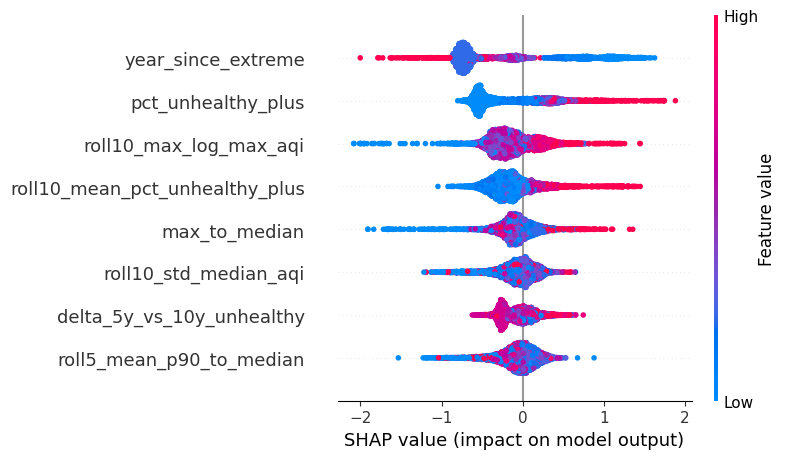

In [71]:
shap.summary_plot(shap_values, X_shap, plot_type="dot")


This Bee Swarm Plot shows what factors matter most
- The strongest driver of predicted extreme-risk is recency of past extreme events: counties that experienced an extreme AQI event more recently show much higher risk.
- Long-term exposure frequency matters next: higher shares of unhealthy days, both current and 10-year averages, consistently push risk upward.
- Historical intensity and spikiness also contribute: counties with larger past AQI peaks or higher max-to-median ratios are more likely to be flagged as high risk.
- Trend signals matter but are weaker: worsening conditions in the last 5 years relative to the 10-year baseline modestly increase risk.

## Decision Plot

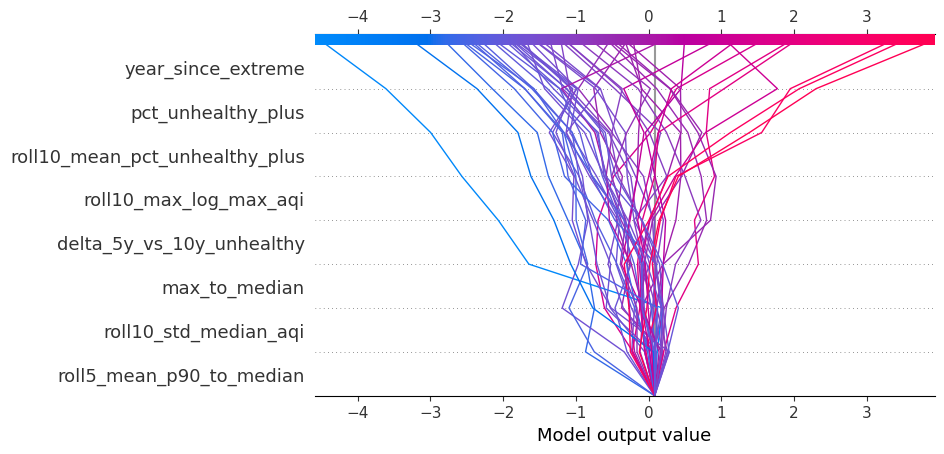

<Figure size 640x480 with 0 Axes>

In [72]:
X_bg = X_imp.sample(n=min(50, len(X_imp)), random_state=42)
sv = explainer.shap_values(X_bg)
if isinstance(sv, list):
    sv = sv[1]

base = explainer.expected_value
if isinstance(base, (list, np.ndarray)):
    base = base[1]

feat_names = X_bg.columns.tolist()

shap.decision_plot(
    base_value=base,
    shap_values=sv,
    features=X_bg,
    feature_names=feat_names,
    feature_order="importance",
    show=True,
)
plt.tight_layout()
plt.show()


The decision plot shows how do these factors jointly push predictions from baseline to extreme risk?
- Most paths diverge early, indicating that a small number of dominant factors largely determine whether a county becomes high risk.
- Counties with higher predicted risk show consistently positive shifts across multiple features, rather than reliance on a single spike.
- Lower-risk counties tend to remain close to the baseline, with small and offsetting contributions across features

## Waterfall Plot on negative value

chosen index: 2716


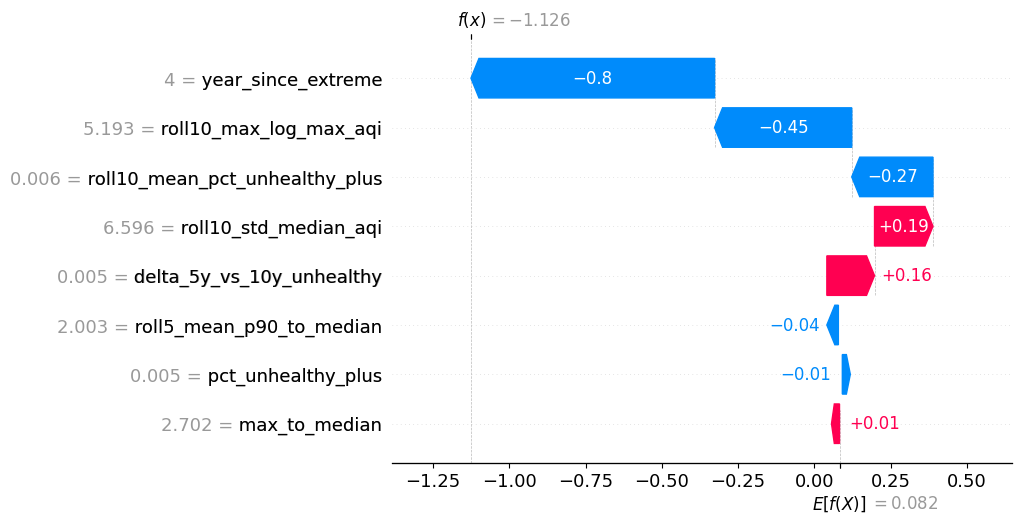

<Figure size 640x480 with 0 Axes>

In [73]:
rng = np.random.default_rng(42)
i = rng.choice(X_imp.index)

print("chosen index:", i)

x_i = X_imp.loc[[i]] 
sv_i = explainer.shap_values(x_i)

if isinstance(sv_i, list):
    sv_i = sv_i[1]

base = explainer.expected_value
if isinstance(base, (list, np.ndarray)):
    base = base[1]
base = float(base)

shap.plots.waterfall(
    shap.Explanation(
        values=sv_i[0],
        base_values=base,
        data=x_i.iloc[0],
        feature_names=X_imp.columns.tolist(),
    ),
    max_display=10, 
)

plt.tight_layout()
plt.show()


## Dependence Plot on `year_since_extreme`

4 years since the last extreme event strongly reduces the predicted extreme risk. 4 years since the last extreme event strongly reduces the predicted extreme risk. Higher variability in median AQI slightly increases the predicted risk. A positive recent–vs–long-term change modestly raises risk.

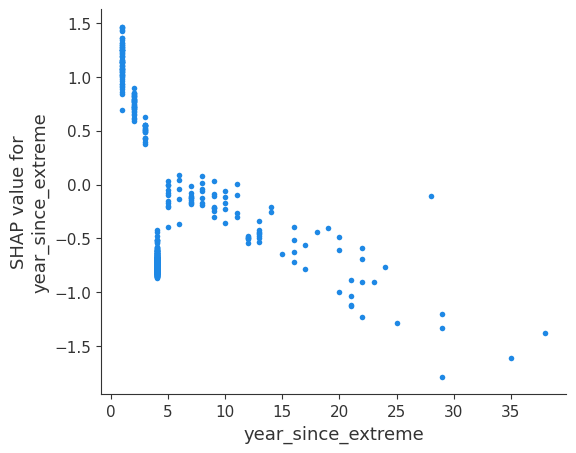

<Figure size 640x480 with 0 Axes>

In [74]:
X_shap = X_imp.sample(n=min(500, len(X_imp)), random_state=42)

sv = explainer.shap_values(X_shap)
if isinstance(sv, list):
    sv = sv[1]

shap.dependence_plot(
    "year_since_extreme",
    sv,
    X_shap,
    interaction_index=None,  
    show=True,
)
plt.tight_layout()
plt.show()


The dependance plot shows a clear negative trend between `year_since_extreme` and its SHAP value.
- Counties that experienced an extreme AQI event more recently have positive SHAP values, which push the model toward higher extreme-risk predictions.
- The influence of past extreme events weakens as they become more distant.